<div style="padding:20px; 
            color:#000000;
            margin:10px;
            font-size:220%;
            text-align:center;
            display:fill;
            border-radius:20px;
            border-width: 5px;
            border-style: solid;
            border-color: #150d0a;
            background-color:#20beff;
            overflow:hidden;
            font-weight:500">Kaggle Survey 2022 Data Exploration</div>

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
plt.style.use('fivethirtyeight')
plt.rcParams["font.family"] = "serif"
tab10= ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
kaggle_blue= '#20beff'
!pip install pywaffle

In [49]:
path= '/kaggle/input/kaggle-survey-2022/kaggle_survey_2022_responses.csv'

# ignore warning because somehow Kaggle is throwing dtype warning
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    df_ori= pd.read_csv(path, skiprows= 0)

<h1 align="center"><font color=#20beff>1. Data Cleaning and Engineering</font></h1>

In [50]:
# map questions to series
map_questions= df_ori.iloc[0, :]
map_questions.sample(3)

Q36_15    Do you use any of the following business intel...
Q31_9     Which of the following cloud computing platfor...
Q44_11    Who/what are your favorite media sources that ...
Name: 0, dtype: object

To group the respondents by skill level, I think it would be interesting to use the K-Means Clustering algorithm to determine the optimal number of groups. This idea came to me after reading a notebook that I came across some time ago, but unfortunately, I can't seem to remember the name of the notebook or locate it now. By using K-Means Clustering, I hope to be able to accurately identify the different skill levels among the respondents and analyze the data in a more meaningful way. Additionally, I believe that this approach will provide a more in-depth understanding of the skill levels within the group and allow me to draw more meaningful conclusions from the data.

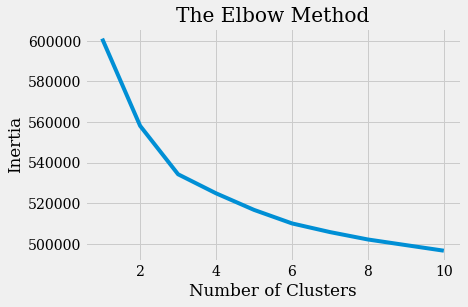

In [51]:
from sklearn.cluster import KMeans

if 'inertias' in locals():
    # if I already run this code, do not run again (saving time)
    pass

else:
    # if I have not run this code, run it
    inertias= []
    for i in range(1,11):
        kmeans = KMeans(n_clusters= i, init='k-means++', random_state=0)
        kmeans.fit(pd.get_dummies(
            (df_ori
                .drop(index= 0)
                .drop(columns= 'Duration (in seconds)')
                .replace('No', 0) 
                .replace('Yes', 1)
                .fillna(0)
            ),
            drop_first= True))
        inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias)
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

<div class="alert alert-block alert-info">
<b>Result:</b> I ran the K-Means Clustering algorithm on the data and determined that dividing the respondents into three groups ("Beginner," "Intermediate," and "Expert") based on their skill level will allow for more accurate analysis and meaningful conclusions. This approach will also enable effective comparison and identification of trends among the different skill levels.
</div>

In [52]:
age_cats= pd.CategoricalDtype([
    '18-21', '22-24', '25-29', '30-34', '35-39', '40-44', 
    '45-49', '50-54', '55-59', '60-69', '70+'], ordered= True)

exp_cats= pd.CategoricalDtype([
    'Blank', 'Not using', 'Under 1 year', '1-2 years', 
    '2-3 years', '3-4 years','4-5 years', '5-10 years', '10-20 years', 
    '20 or more years'], ordered= True)

group_cats= pd.CategoricalDtype(['Beginner', 'Intermediate', 'Expert'], ordered= True)

kmeans_model= KMeans(n_clusters= 3, init='k-means++', random_state= 0)

def clean_df(df):
    return(df
        .drop(index= 0) # drop row containing queston
        .drop(columns= 'Duration (in seconds)') # drop duration col
        .fillna(0) # fill na with 0
        .replace('No', 0) 
        .replace('Yes', 1)
        .assign(
            Q2= lambda df_: df_['Q2'].astype(age_cats), # age cat
            Q16= lambda df_: (df_['Q16']
                              .replace({0: 'Blank', 'I do not use machine learning methods': 'Not using'})
                              .astype(exp_cats)),
            Group= lambda df_: kmeans_model.fit_predict(pd.get_dummies(df_, drop_first= True)) # group cat, obtained by kmeans
        )
        .assign(
            # rename group to their respective group name
            Group= lambda df_: (df_['Group'].map({0: 'Intermediate', 1: 'Expert', 2: 'Beginner'})).astype(group_cats)
        )
    )

In [53]:
df= clean_df(df_ori)

<h1 align="center"><font color='#20beff'>2. Data Exploration</font></h1>

In [54]:
# define helper functions that I'm gonna be using

def plot_var_per_group(var, var_name, dataframe= df, annotate= False, palette= 'summer', figsize= (15, 5)):
    plt.figure(figsize= figsize)   
    try:
        ax= sns.barplot(
            data= (dataframe
                    .groupby('Group')[var]
                    .value_counts(normalize= True)
                    .mul(100)
                    .to_frame()
                    .reset_index()
                    .rename({'level_1': var_name, var: 'Percentage'}, axis= 'columns')
                    .sort_values(var_name)
                    ),
            y= 'Percentage',
            x= 'Group',
            hue= var_name,
            palette= palette
        )  
    except:
         ax= sns.barplot(
            data= (dataframe
                .groupby('Group')[var]
                .value_counts(normalize= True)
                .mul(100)
                .to_frame()
                .rename(columns= {var: 'Percentage'})
                .reset_index()
                .rename({var: var_name}, axis= 'columns')
                .sort_values(var_name)
            ),
            y= 'Percentage',
            x= 'Group',
            hue= var_name,
            palette= palette
        )       
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals= 0))
    plt.legend(ncol= 6, loc= 'upper center', bbox_to_anchor=(0.5, 1.2), frameon= False)
    title= map_questions[var]
    plt.title(title, fontsize= 30, fontweight= 'bold', pad= 80)
    plt.ylabel('Percentage')
    plt.xlabel('')
    if annotate == True:
        for p in ax.patches:
            ax.annotate(format(p.get_height()/100, '.1%',), 
                           (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', va = 'center', 
                           size= 10,
                           xytext = (0, 10), 
                           textcoords = 'offset points')
    plt.show()
    
    
def plot_var_per_group2(df1, df2, y, title, upper_xlim, y_title= 1.3):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1= sns.barplot(
        data= df1,
        y= y,
        x= 'value',
        hue= 'Group',
        palette= 'Set1',
        ax= ax1
    )
    ax2= sns.barplot(
        data= df2,
        y= y,
        x= 'value',
        hue= 'Group', 
        palette= 'Set1',
        ax= ax2
    )
    for ax in (ax1, ax2):
        ax.legend([],[], frameon=False) 
        ax.set_ylabel('')
        ax.set_xlabel('Count')
        ax.set_xlim(0, upper_xlim)
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor= (0.5, 1.05), ncol= 3, frameon= False)
    plt.suptitle(title, fontsize= 30, fontweight= 'bold', y= y_title)
    plt.show()
    
def plot_bidirectional_barplot(suptitle, index, column1, title1, column2, title2, plot_size, title_pad= 25):
    color1= '#1f77b4'
    color2= '#d62728'

    fig, (ax1, ax2) = plt.subplots(figsize= plot_size, ncols=2, sharey= True)

    ax1.barh(index, column1, align='center', color= color1, zorder=10)
    ax1.set_title(title1, fontsize=18, pad= title_pad, color= color1)

    ax2.barh(index, column2, align='center', color= color2, zorder=10)
    ax2.set_title(title2, fontsize=18, pad= title_pad, color= color2)

    plt.gca().invert_yaxis() # sort y-axis a-z
    ax1.invert_xaxis() # invery y axis from ax2

    # sey both ylim to 0-100
    ax2.set_xticks(list(range(0, 120, 20)))
    ax2.set_xticks(list(reversed((range(0, 120, 20)))))

    for ax in (ax1, ax2):
#         ax.xaxis.set_visible(False)
        ax.xaxis.tick_top()
        ax.tick_params(axis='x', which='major', pad= -(ax.get_ylim()[0]/2))
        ax.spines.right.set_visible(False)
        ax.spines.left.set_visible(False)
        ax.spines.top.set_visible(False)
        ax.spines.bottom.set_visible(False)
        
    plt.suptitle(suptitle, fontsize= 30, fontweight= 'bold', y= 1)

    fig.tight_layout()
    plt.show()
    
def plot_waffle(title, num_col, values, labels, figsize= (15, 5), colors = tab10, 
    x_title= 0.43, y_title= 1.4, legend_bbox= (0.43, 1.3), n_col_legend= 6):
    
    from pywaffle import Waffle
    
    num_labels= len(labels)
    diff= num_labels - len(colors)
    for i in list(range(0, diff)):
        colors.append(colors[i])

    ax = plt.figure(
        FigureClass= Waffle, 
        columns = num_col, 
        values= values,
        labels= labels,
        rounding_rule='floor',
        figsize= figsize,
        colors= colors,
        title={
            'label': title,
            'loc': 'center',
            'x': x_title,
            'y': y_title,
            'fontdict': {
                'fontsize': 30,
                'fontweight': 'bold'
            }
        },
        legend={
            'loc': 'upper center',
            'bbox_to_anchor': legend_bbox,
            'ncol': n_col_legend,
            'framealpha': 0,
            'fontsize': 12
        }
    )
    
def plot_normalized_hbar(data, title, figsize= (15, 12)):
                  
    category_names= data.columns.tolist()
    labels= data.index.tolist()
    data= np.array(data)

    data_cum = data.cumsum(axis=1)
    category_colors = plt.colormaps['RdYlGn'](
        np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize= figsize, dpi= 150)
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(labels, widths, left=starts, height=0.8,
                        label=colname, color=color)

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        ax.bar_label(rects, fmt= '%.1f%%', label_type='center', color=text_color)
    ax.legend(ncol=len(category_names), loc='upper center', bbox_to_anchor= (0.5, 1.05), frameon= False)
    ax.set_title(title, fontsize= 30, fontweight= 'bold', pad= 70)

    return fig, ax

def plot_donut(data, title, colormap= 'coolwarm', figsize= (8, 8)):
    
    fig, ax= plt.subplots(figsize= figsize)
    
    #to add percentages
    def autopct(pct):
        return ('%.1f%%' % pct) if pct > 1 else ''

    #to add labels
    def get_new_labels(sizes, labels):
        new_labels = [label for size, label in zip(sizes, labels)]
        return new_labels

    sizes = data.values
    labels = data.index
    ax = data.plot(
        kind= 'pie',
        autopct= autopct, 
        labels= get_new_labels(sizes, labels), 
        colormap= colormap
    )

    ax.set_title(title, fontsize= 30, fontweight= 'bold', pad= 0)
    ax.set_ylabel('')

    # draw circle
    centre_circle = plt.Circle((0, 0), 0.75, fc='white')
    fig = plt.gcf()
    # add circle in chart
    fig.gca().add_artist(centre_circle)

    plt.show()

<h2 align="center"><font color='#20beff'>2.1 Age</font></h2>

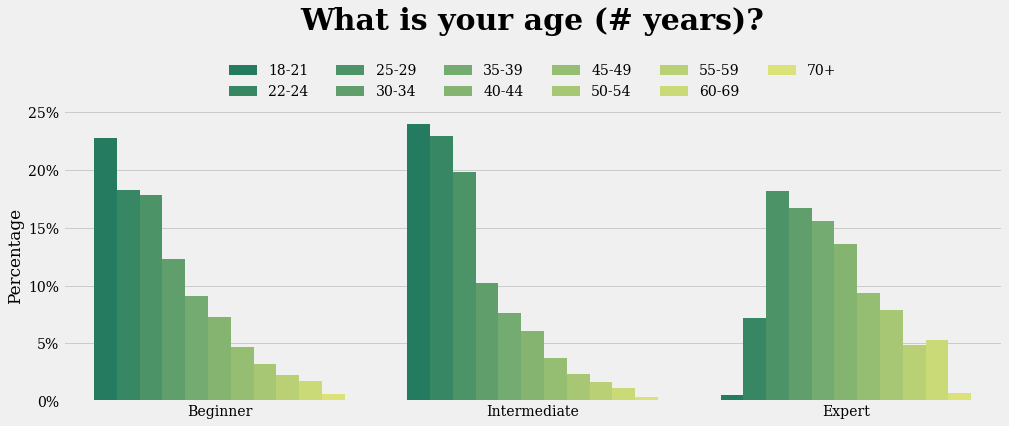

In [55]:
plot_var_per_group('Q2', 'Age')

<div class="alert alert-block alert-info">
<b>Insight:</b> Majority of Beginner and Intermediate are people in their 20. Expert, on the other hand, tends to be older.
</div>

<h2 align="center"><font color='#20beff'>2.2 Country</font></h2>

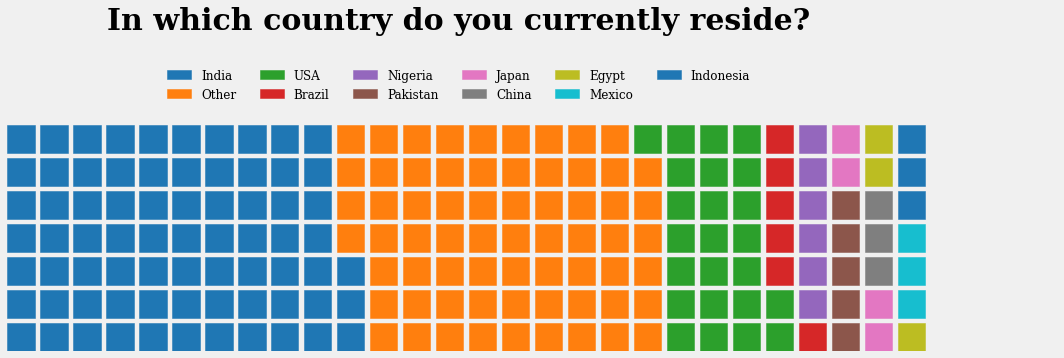

In [56]:
countries= df['Q4'].value_counts(normalize= True)
countries['Other'] = countries['Other'] + countries[11:].sum()
countries_top10= countries[:11].sort_values(ascending= False)
countries_top10= countries_top10.rename(index= {'United States of America': 'USA'})

plot_waffle(
    title= map_questions['Q4'], 
    num_col= 32, 
    values= list(countries_top10.values * 200), 
    labels= list(countries_top10.index)
)

<div class="alert alert-block alert-info">
<b>Insight:</b> India is still the country with the largest population of respondents.
</div>

<h2 align="center"><font color='#20beff'>2.3 Gender</font></h2>

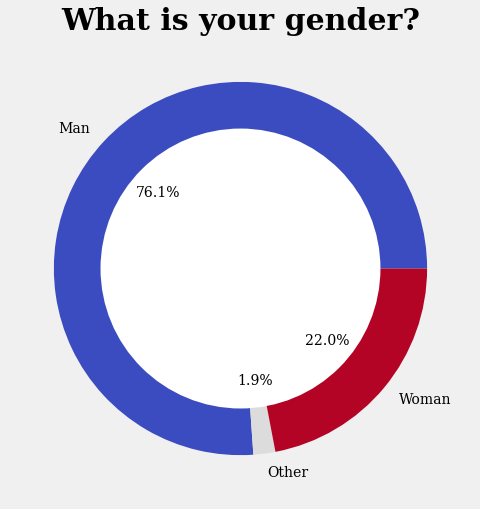

In [57]:
data= (df
    .loc[:, 'Q3']
    .where((df['Q3'] == 'Man') | (df['Q3'] == 'Woman'), 'Other')
    .value_counts(normalize= True)
    .sort_index()
    .mul(100)
    .round(1)
)

plot_donut(data, title= map_questions['Q3'].replace(' - Selected Choice', ''))

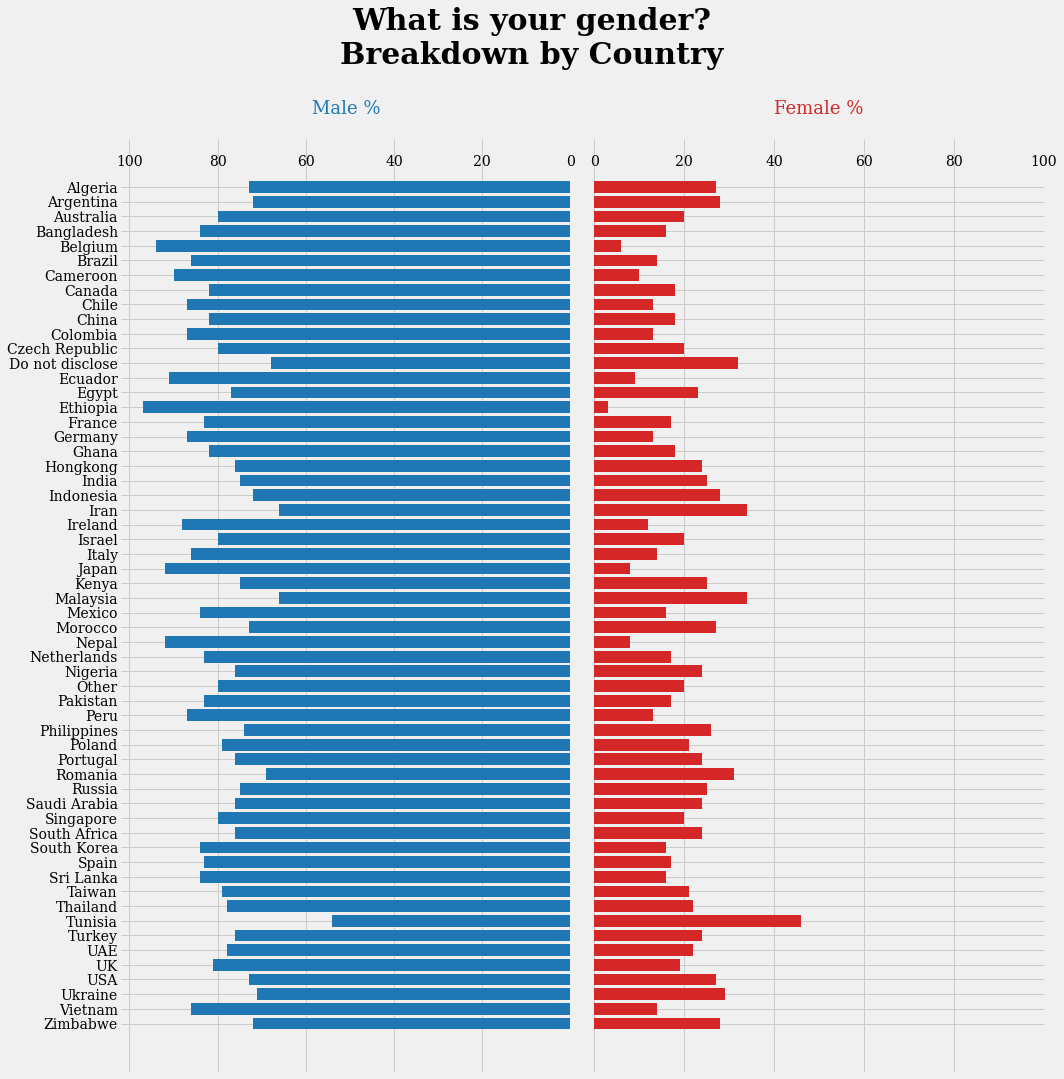

In [58]:
map_country= {
    'United States of America': 'USA',
    'United Kingdom of Great Britain and Northern Ireland': 'UK',
    'Iran, Islamic Republic of...': 'Iran',
    'Viet Nam': 'Vietnam',
    'United Arab Emirates': 'UAE',
    'Hong Kong (S.A.R.)': 'Hongkong',
    'I do not wish to disclose my location': 'Do not disclose'
}

df_q4= (df
    ['Q4']
    .replace(map_country)
    .to_frame()
    .assign(
        Gender= df['Q3'].where(df['Q3'].isin(['Man', 'Woman']), 'Other')
    )
    .query('`Gender` != "Other"')
    .groupby(['Q4', 'Gender'])
    .agg(Count= ('Gender', 'size'))
    .reset_index()
    .rename(columns= {'Q4': 'Nationality'})
    .assign(Perc= lambda df_: round(((df_['Count'] / df_.groupby('Nationality')['Count'].transform('sum'))* 100), 0))
    .pivot(index= 'Nationality', columns= 'Gender', values= 'Perc')
)

plot_bidirectional_barplot(
    suptitle= 'What is your gender?\nBreakdown by Country',
    index = df_q4.index, 
    column1 = df_q4['Man'], title1 = 'Male %', 
    column2 = df_q4['Woman'], title2 = 'Female %', 
    plot_size= (15,15)
)

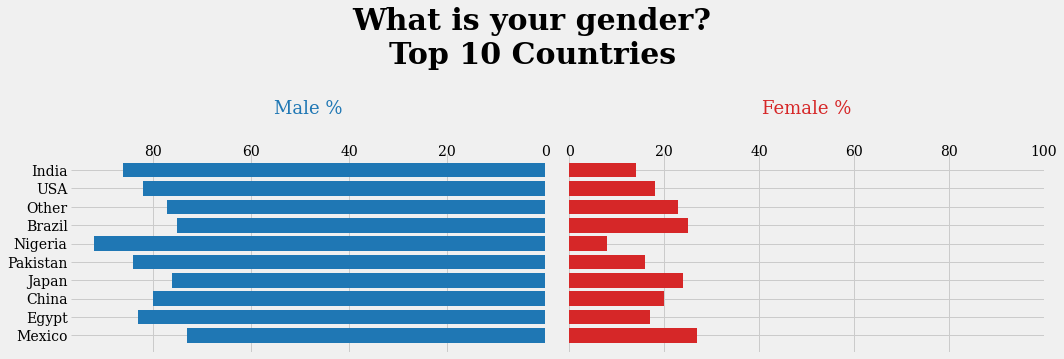

In [59]:
top10_countries= df['Q4'].value_counts()[:10].index.tolist()
# replace united states with usa
top10_countries= ['USA' if x == 'United States of America' else x for x in top10_countries] 

df_q4_selected= (df_q4
    .loc[df_q4.index.isin(top10_countries)]
    .set_index(pd.CategoricalIndex(top10_countries, ordered= True))
)

plot_bidirectional_barplot(
    suptitle= 'What is your gender?\nTop 10 Countries',
    index = df_q4_selected.index, 
    column1 = df_q4_selected['Man'], title1 = 'Male %', 
    column2 = df_q4_selected['Woman'], title2 = 'Female %', 
    plot_size= (15, 5),
    title_pad= 40
)

<div class="alert alert-block alert-info">
<b>Insight:</b> Men still dominate the Data Science Industry in number. 
</div>

<h2 align="center"><font color='#20beff'>2.4 Machine Learning Experience</font></h2>

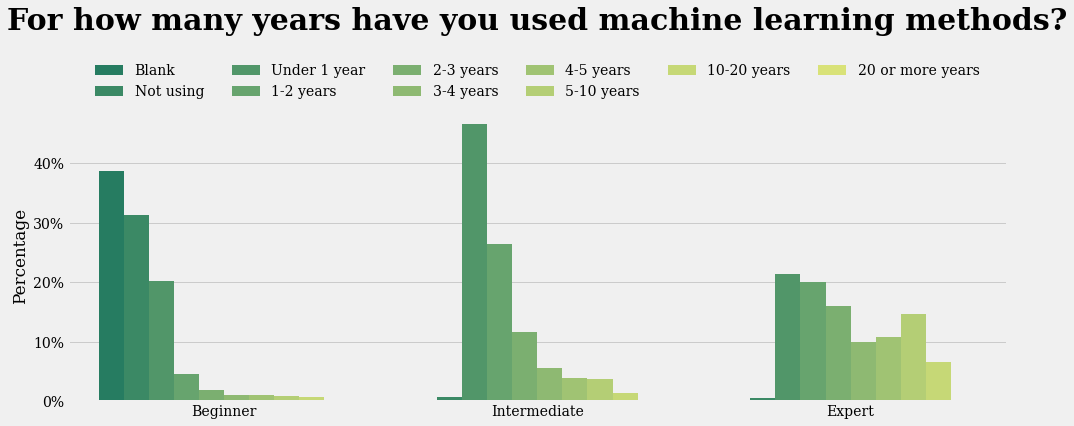

In [60]:
plot_var_per_group('Q16', 'ML Experience')

<div class="alert alert-block alert-info">
<b>Insight:</b> The longer one has used ML methods, the higher thay are in our group, which is not surprising.
</div>

<h2 align="center"><font color='#20beff'>2.5 Data Science Course</font></h2>

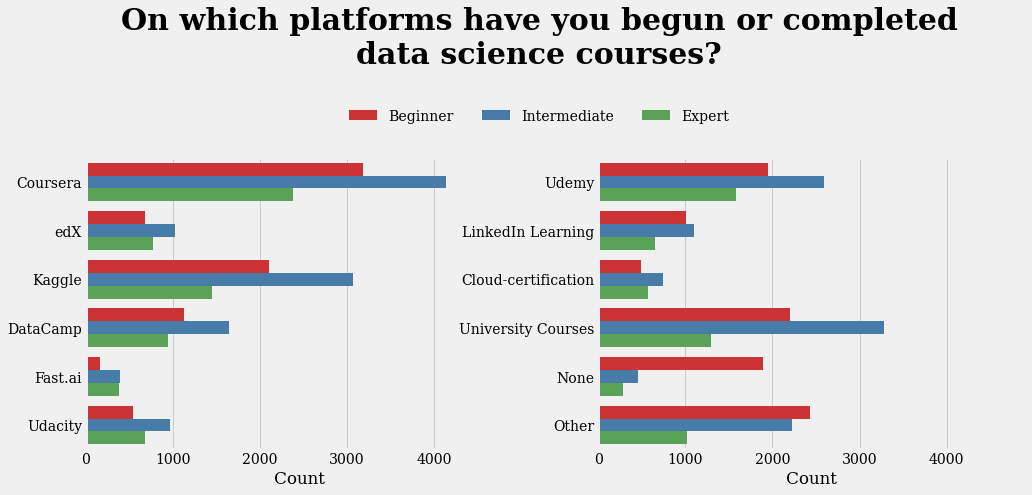

In [61]:
import re
mask_question= df.columns[df.columns.str.contains('Q6')]
df_q6= (df[mask_question]
    .mask(df != 0, 1)
    .rename(columns= dict(map_questions))
    .join(df['Group'])
)
df_q6.columns= (df_q6.columns
    .str.replace('On which platforms have you begun or completed data science courses? (Select all that apply) - Selected Choice - ', '', regex= False)
    .str.replace(' (direct from AWS, Azure, GCP, or similar)', '', regex= False)
    .str.replace(' (resulting in a university degree)', '', regex= False)
    .str.replace(' Learn Courses', '', regex= False)
    .str.replace(' programs', '', regex= False)
)
df_q6= (df_q6
    .groupby('Group')
    .sum()
    .reset_index()
    .melt(id_vars= 'Group')
)

plot_var_per_group2(
    df_q6.iloc[0:int(len(df_q6)/2),:],
    df_q6.iloc[int(len(df_q6)/2):,:], 
    'variable', 
    "On which platforms have you begun or completed\ndata science courses?", 
    4900
)

<h2 align="center"><font color='#20beff'>2.6 Programming Language</font></h2>

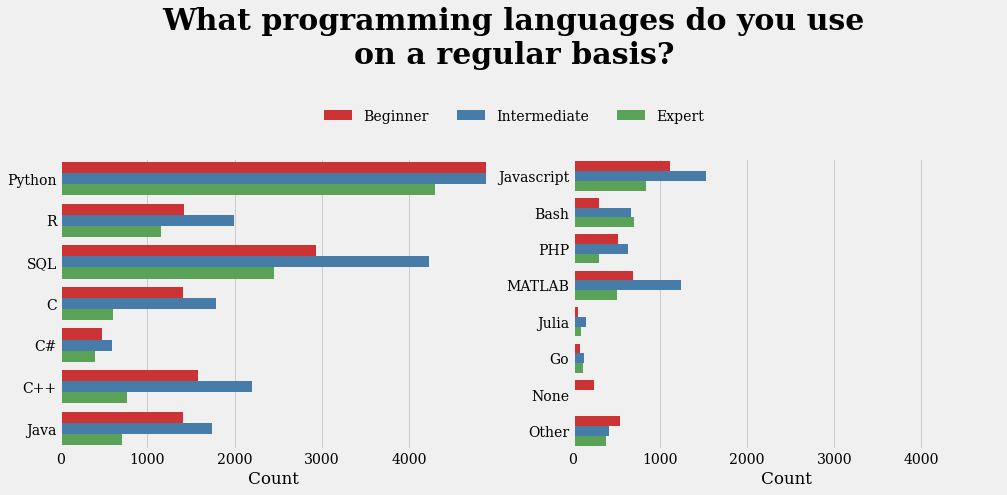

In [62]:
mask_question= df.columns[df.columns.str.contains('Q12')]
df_q12= (df[mask_question]
    .mask(df != 0, 1)
    .rename(columns= dict(map_questions))
    .join(df['Group'])
    .rename(columns= lambda c: c.replace('What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - ', ''))
    .groupby('Group')
    .sum()
    .reset_index()
    .melt(id_vars= 'Group')
)

plot_var_per_group2(
    df_q12.iloc[0:int(len(df_q12)/2 - 1),:],
    df_q12.iloc[int(len(df_q12)/2 - 1):,:], 
    'variable', 
    "What programming languages do you use\non a regular basis?", 
    4900
)

<h2 align="center"><font color='#20beff'>2.7 IDE</font></h2>

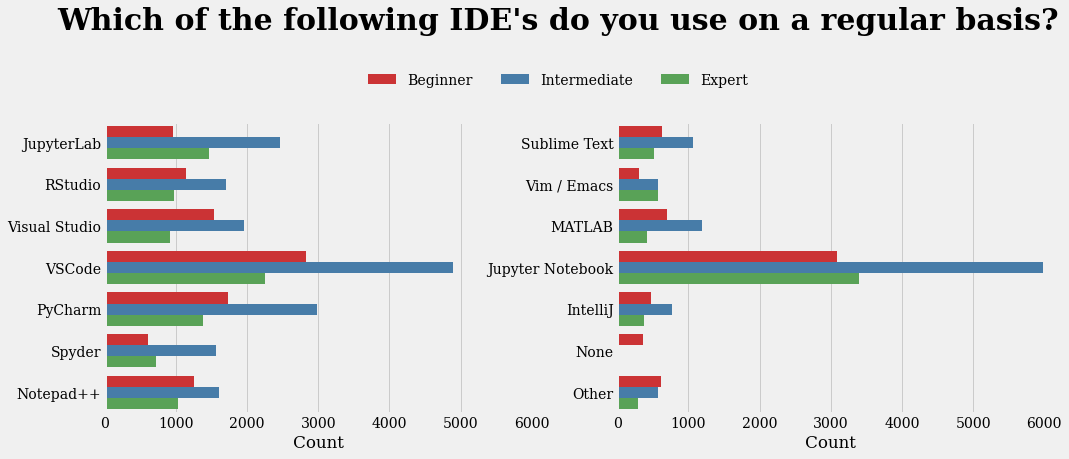

In [63]:
mask_question= df.columns[df.columns.str.contains('Q13')]
df_q13= (df[mask_question]
    .mask(df != 0, 1)
    .rename(columns= dict(map_questions))
    .join(df['Group'])
    .rename(
        columns= lambda c: (c
            .replace("Which of the following integrated development environments (IDE's) do you use on a regular basis?", '')
            .replace("(Select all that apply) - Selected Choice -", '')
            .replace("Visual Studio Code (VSCode)", 'VSCode')
            .strip()
                            
    ))
    .groupby('Group')
    .sum()
    .reset_index()
    .melt(id_vars= 'Group')
)

plot_var_per_group2(
    df_q13.iloc[0:int(len(df_q12)/2)-1,:],
    df_q13.iloc[int(len(df_q12)/2)-1:,:], 
    'variable', 
    "Which of the following IDE's do you use on a regular basis?", 
    6000,
    1.2
)

<h2 align="center"><font color='#20beff'>2.8 Machine Learnig Adoption</font></h2>

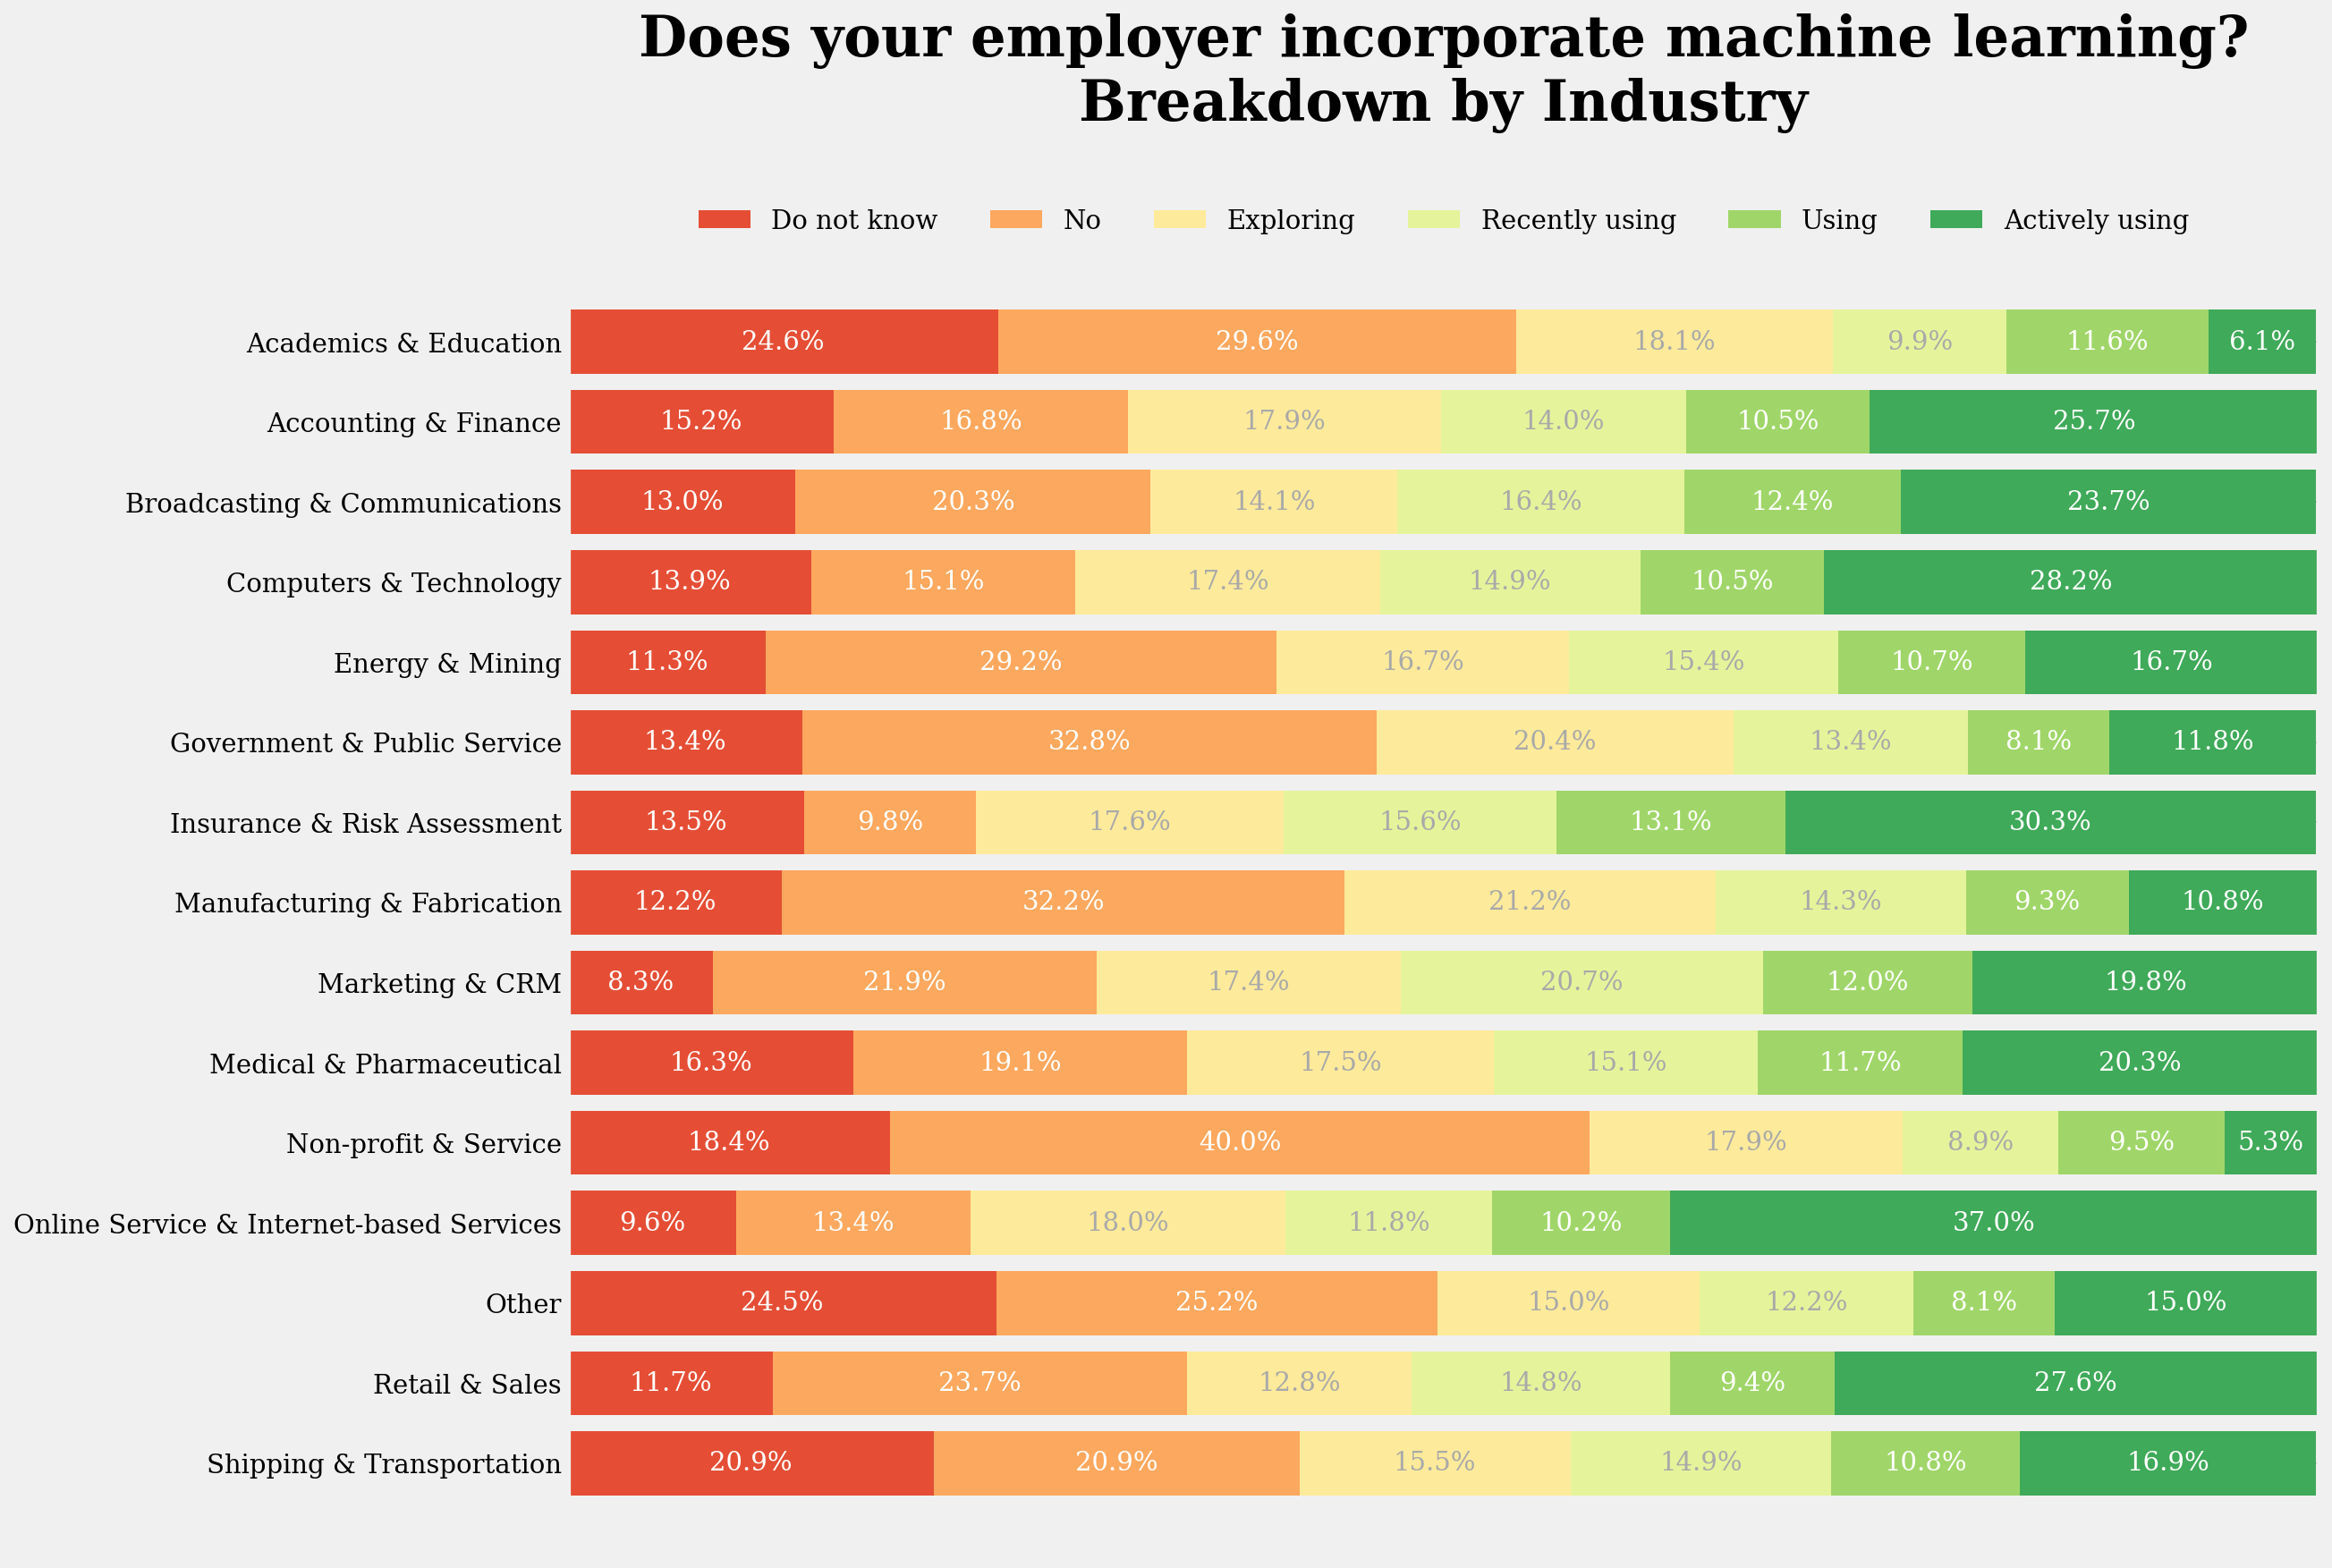

In [64]:
data_q24_q27= (df
    [['Q24', 'Q27']]
    .query('Q24 != 0 & Q27 != 0')
    .assign(
        Q24= lambda df_: df_['Q24'].str.replace('/', ' & ', regex= False),
        Q27= lambda df_: df_['Q27'].str.replace(' \(.+\)', '', regex= True).replace({
            'We recently started using ML methods': 'Recently using', 
            'We have well established ML methods': 'Actively using',
            'We are exploring ML methods': 'Exploring',
            'I do not know': ' Do not know',
            'We use ML methods for generating insights': 'Using'
        }).str.strip()
    )
    .assign(
        Q27= lambda df_: df_['Q27'].astype(pd.CategoricalDtype(
            categories= ['Do not know', 'No', 'Exploring', 'Recently using', 'Using', 'Actively using'], ordered= True
        ))
    )
    .groupby(['Q24', 'Q27'])
    .agg(Count= ('Q24', 'size'))
    .reset_index()
    .assign(
        Perc= lambda df_ : round((df_['Count'] / df_.groupby('Q24')['Count'].transform('sum') * 100), 1)
    ) 
    .pivot_table(index= 'Q24', columns= ['Q27'], values= 'Perc')
)

title= 'Does your employer incorporate machine learning?\nBreakdown by Industry'
plot_normalized_hbar(data= data_q24_q27, title= title)
plt.show()

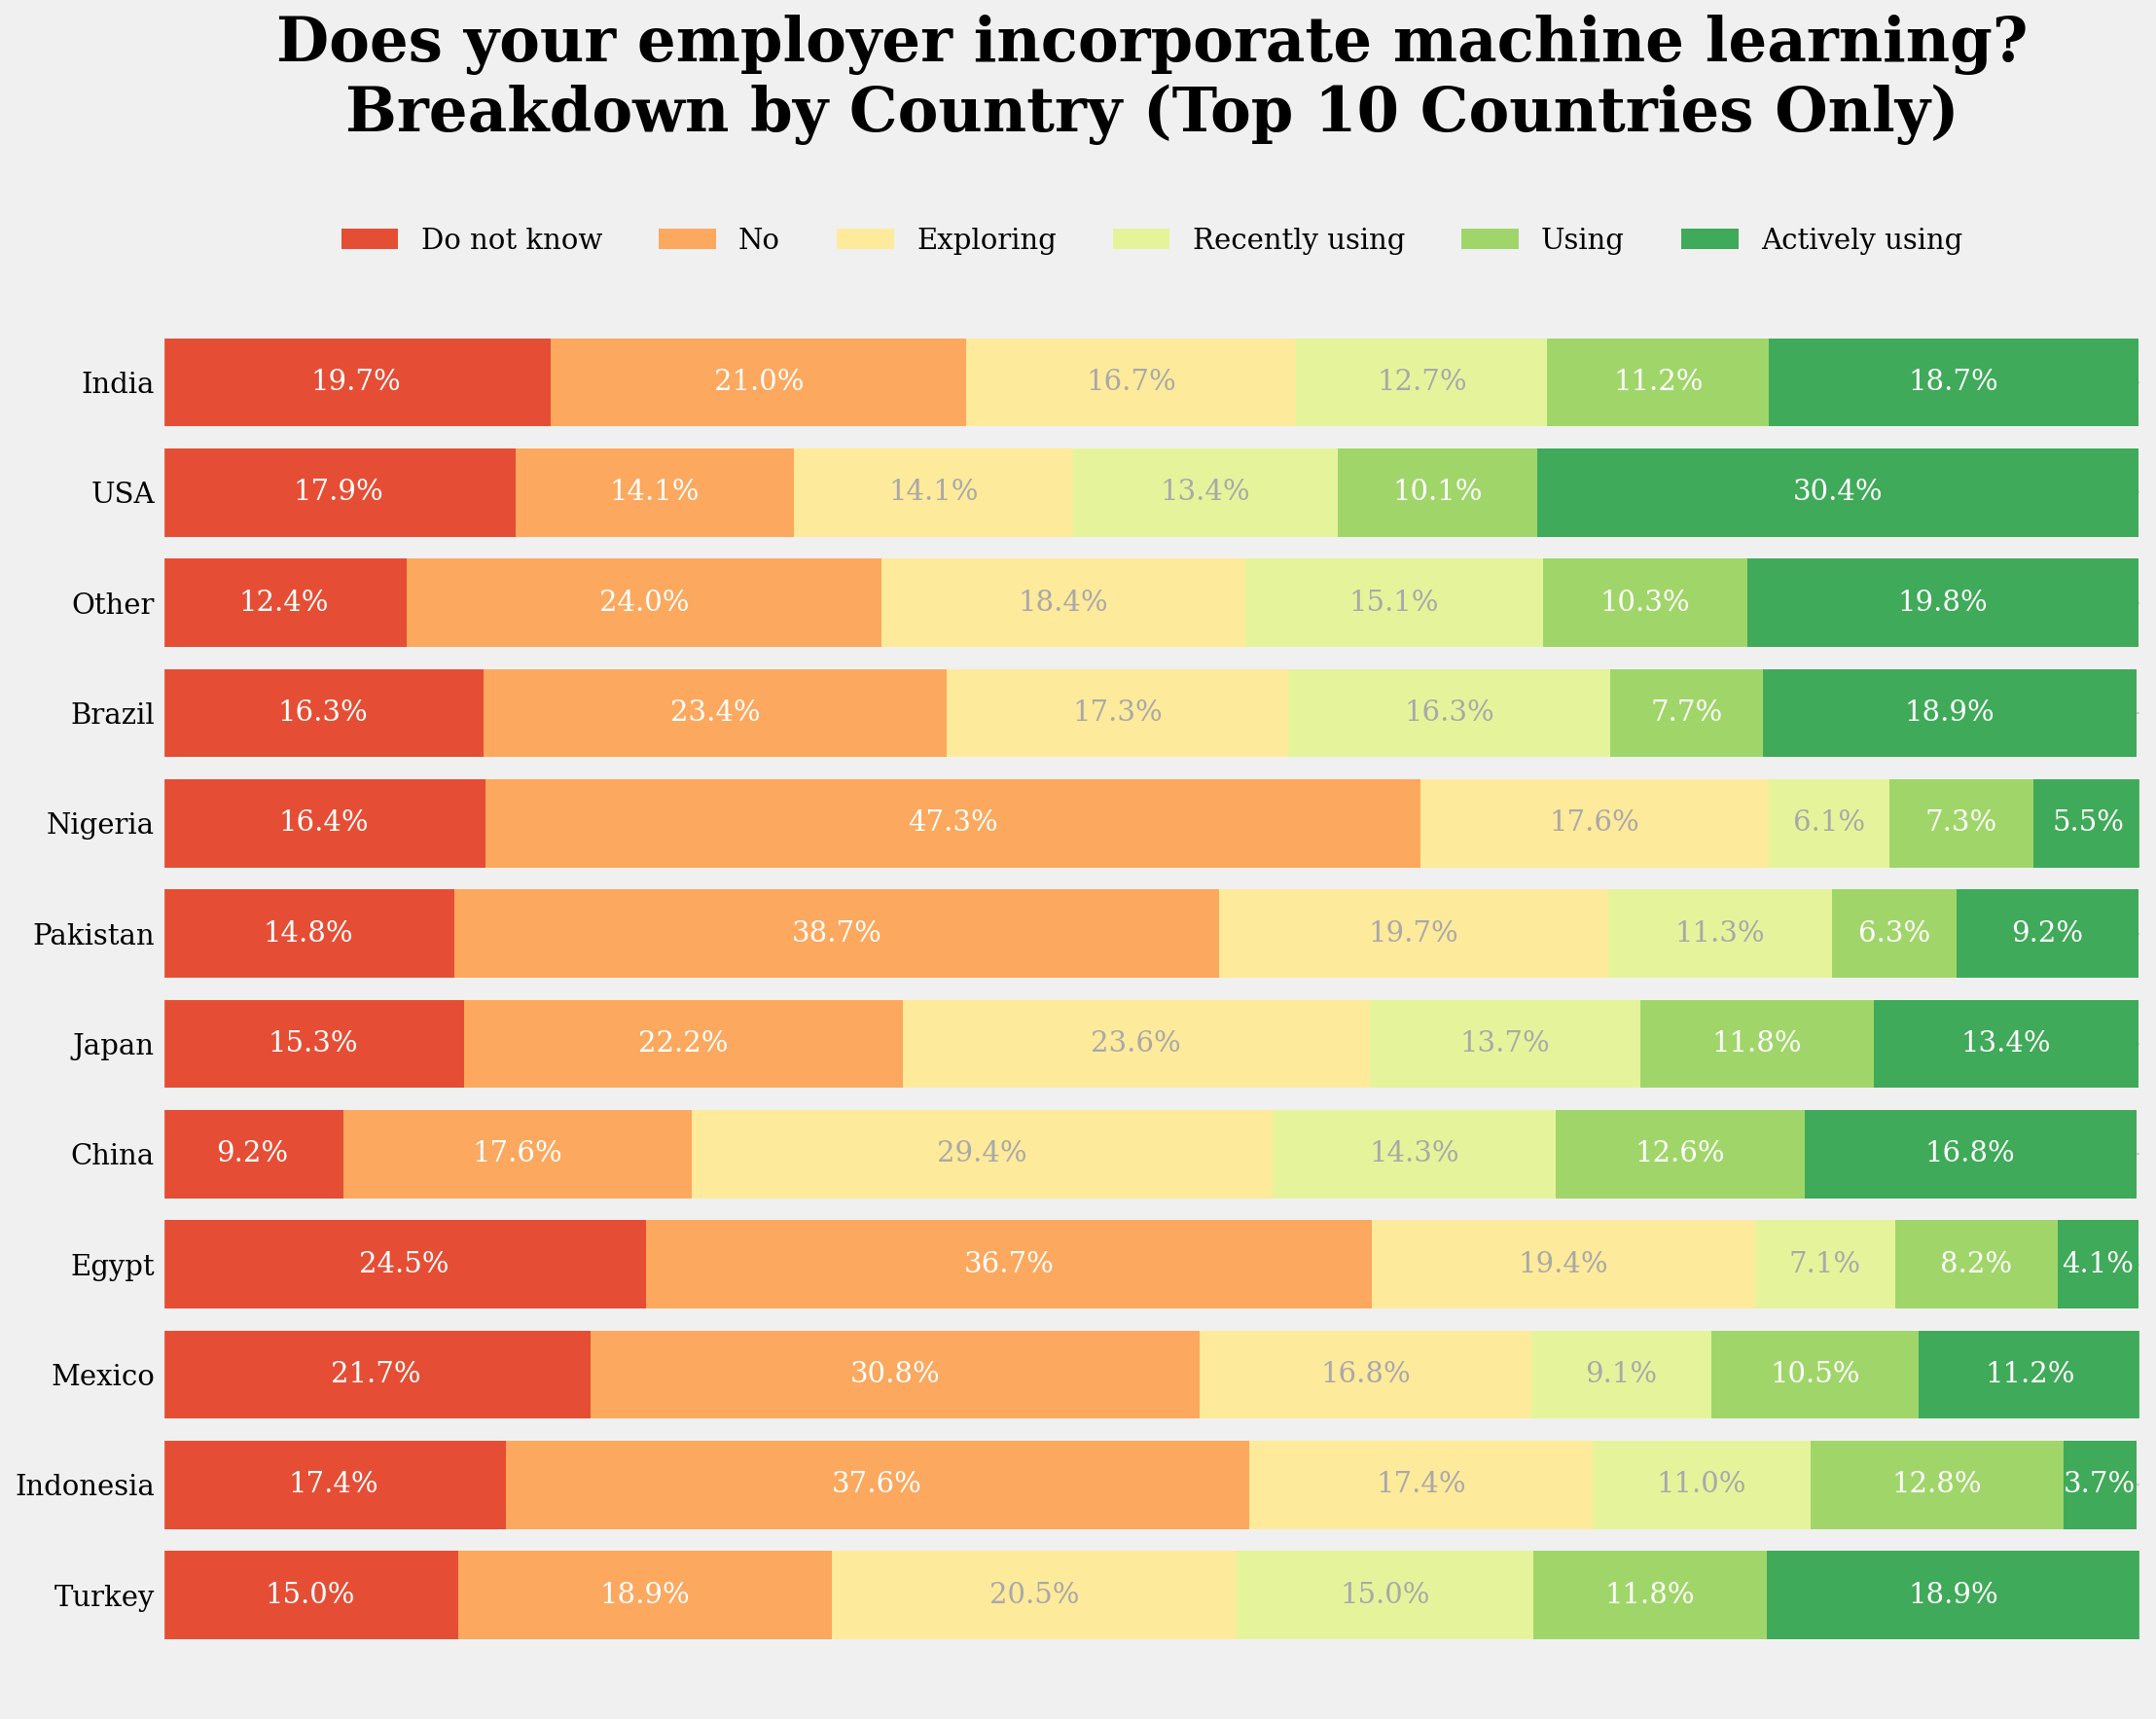

In [78]:
top_10_countries= (df
    ['Q4']
    .value_counts()
    [:12]
    .index
)

data_q4_q27= (df
    [['Q4', 'Q27']]
    .query('Q27 != 0')
    .assign(
        Q4= lambda df_: (df_['Q4'].where(df_['Q4'].isin(top_10_countries), 'Other')),
        Q27= lambda df_: df_['Q27'].str.replace(' \(.+\)', '', regex= True).replace({
            'We recently started using ML methods': 'Recently using', 
            'We have well established ML methods': 'Actively using',
            'We are exploring ML methods': 'Exploring',
            'I do not know': ' Do not know',
            'We use ML methods for generating insights': 'Using'
        }).str.strip()
    )
    .assign(
        Q4= lambda df_: df_['Q4'].astype(pd.CategoricalDtype(categories= top_10_countries, ordered= True)),
        Q27= lambda df_: df_['Q27'].astype(pd.CategoricalDtype(
            categories= ['Do not know', 'No', 'Exploring', 'Recently using', 'Using', 'Actively using'], ordered= True
        ))
    )
    .groupby(['Q4', 'Q27'])
    .agg(Count= ('Q4', 'size'))
    .reset_index()
    .assign(
        Perc= lambda df_ : round((df_['Count'] / df_.groupby('Q4')['Count'].transform('sum') * 100), 1)
    ) 
    .pivot_table(index= 'Q4', columns= ['Q27'], values= 'Perc')
    .rename(index= {'United States of America': 'USA'})
)

title= 'Does your employer incorporate machine learning?\nBreakdown by Country (Top 10 Countries Only)'
plot_normalized_hbar(data= data_q4_q27, title= title)
plt.tight_layout()
plt.savefig('output.png')
plt.show()

<h2 align="center"><font color='#20beff'>2.9 Role</font></h2>

In [66]:
df['Q23'].value_counts()

0                                                                   13367
Data Scientist                                                       1929
Data Analyst (Business, Marketing, Financial, Quantitative, etc)     1538
Currently not employed                                               1432
Software Engineer                                                     980
Teacher / professor                                                   833
Manager (Program, Project, Operations, Executive-level, etc)          832
Other                                                                 754
Research Scientist                                                    593
Machine Learning/ MLops Engineer                                      571
Engineer (non-software)                                               465
Data Engineer                                                         352
Statistician                                                          125
Data Architect                        

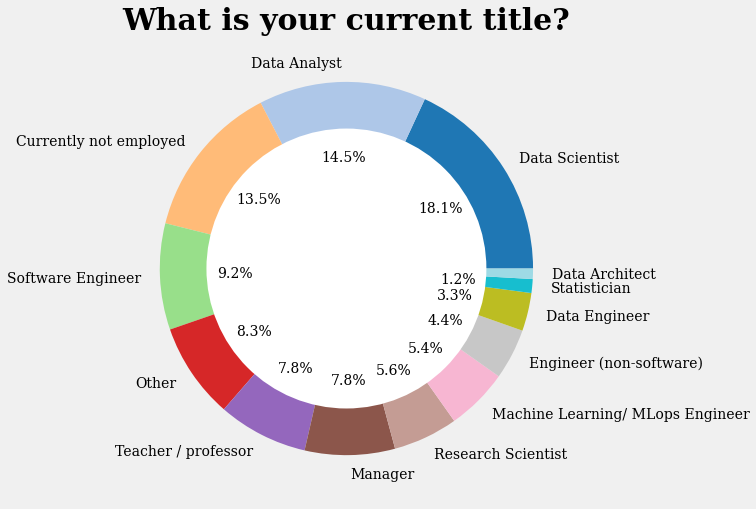

In [67]:
data= (df
    .loc[df['Q23'] != 0, 'Q23']
    .where(
        df['Q23'].isin(df['Q23'].value_counts()[:14].index),
        'Other'
    )
    .replace({
        'Data Analyst (Business, Marketing, Financial, Quantitative, etc)': 'Data Analyst',
        'Manager (Program, Project, Operations, Executive-level, etc)': 'Manager'
    })
    .value_counts(normalize= True)
    .mul(100)
    .round(1)
)

plot_donut(
    data, 
    title= 'What is your current title?', 
    colormap= 'tab20'
)

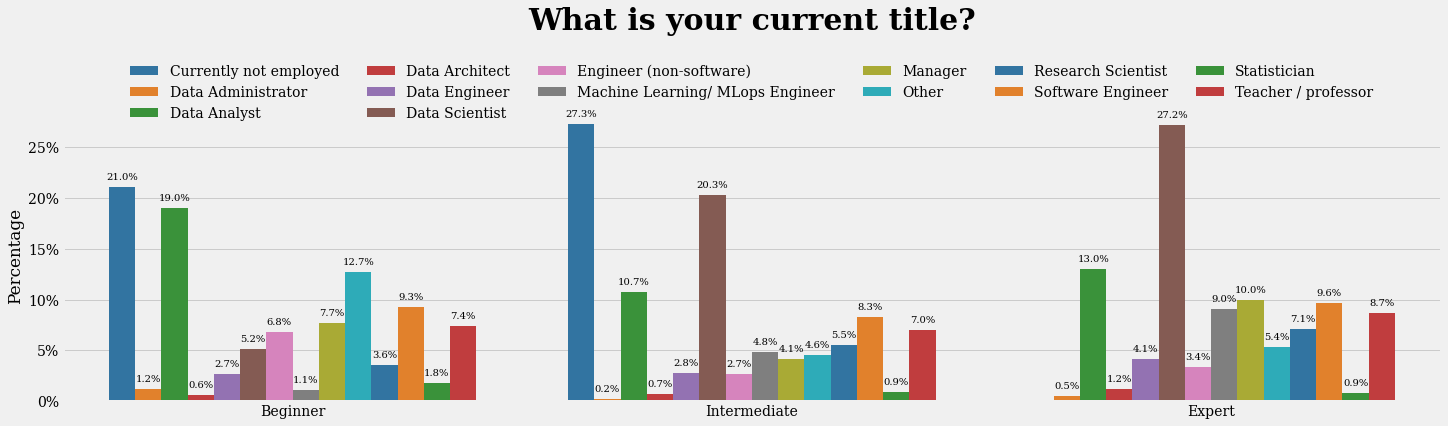

In [68]:
data= (df
    .loc[df['Q23'] != 0, :]
    .assign(
        Q23= lambda df_: df_['Q23'].where(
            df_['Q23'].isin(df_['Q23'].value_counts()[:14].index),
            'Other'
        )
    )
    .assign(
        Q23= lambda df_: df_['Q23'].replace({
            'Data Analyst (Business, Marketing, Financial, Quantitative, etc)': 'Data Analyst',
            'Manager (Program, Project, Operations, Executive-level, etc)': 'Manager'
            })
    )
)

map_questions['Q23'] = 'What is your current title?'
plot_var_per_group('Q23', 'Role', dataframe= data, figsize= (22, 5), palette= 'tab10', annotate= True)

<h2 align="center"><font color='#20beff'>2.10 Compensation</font></h2>

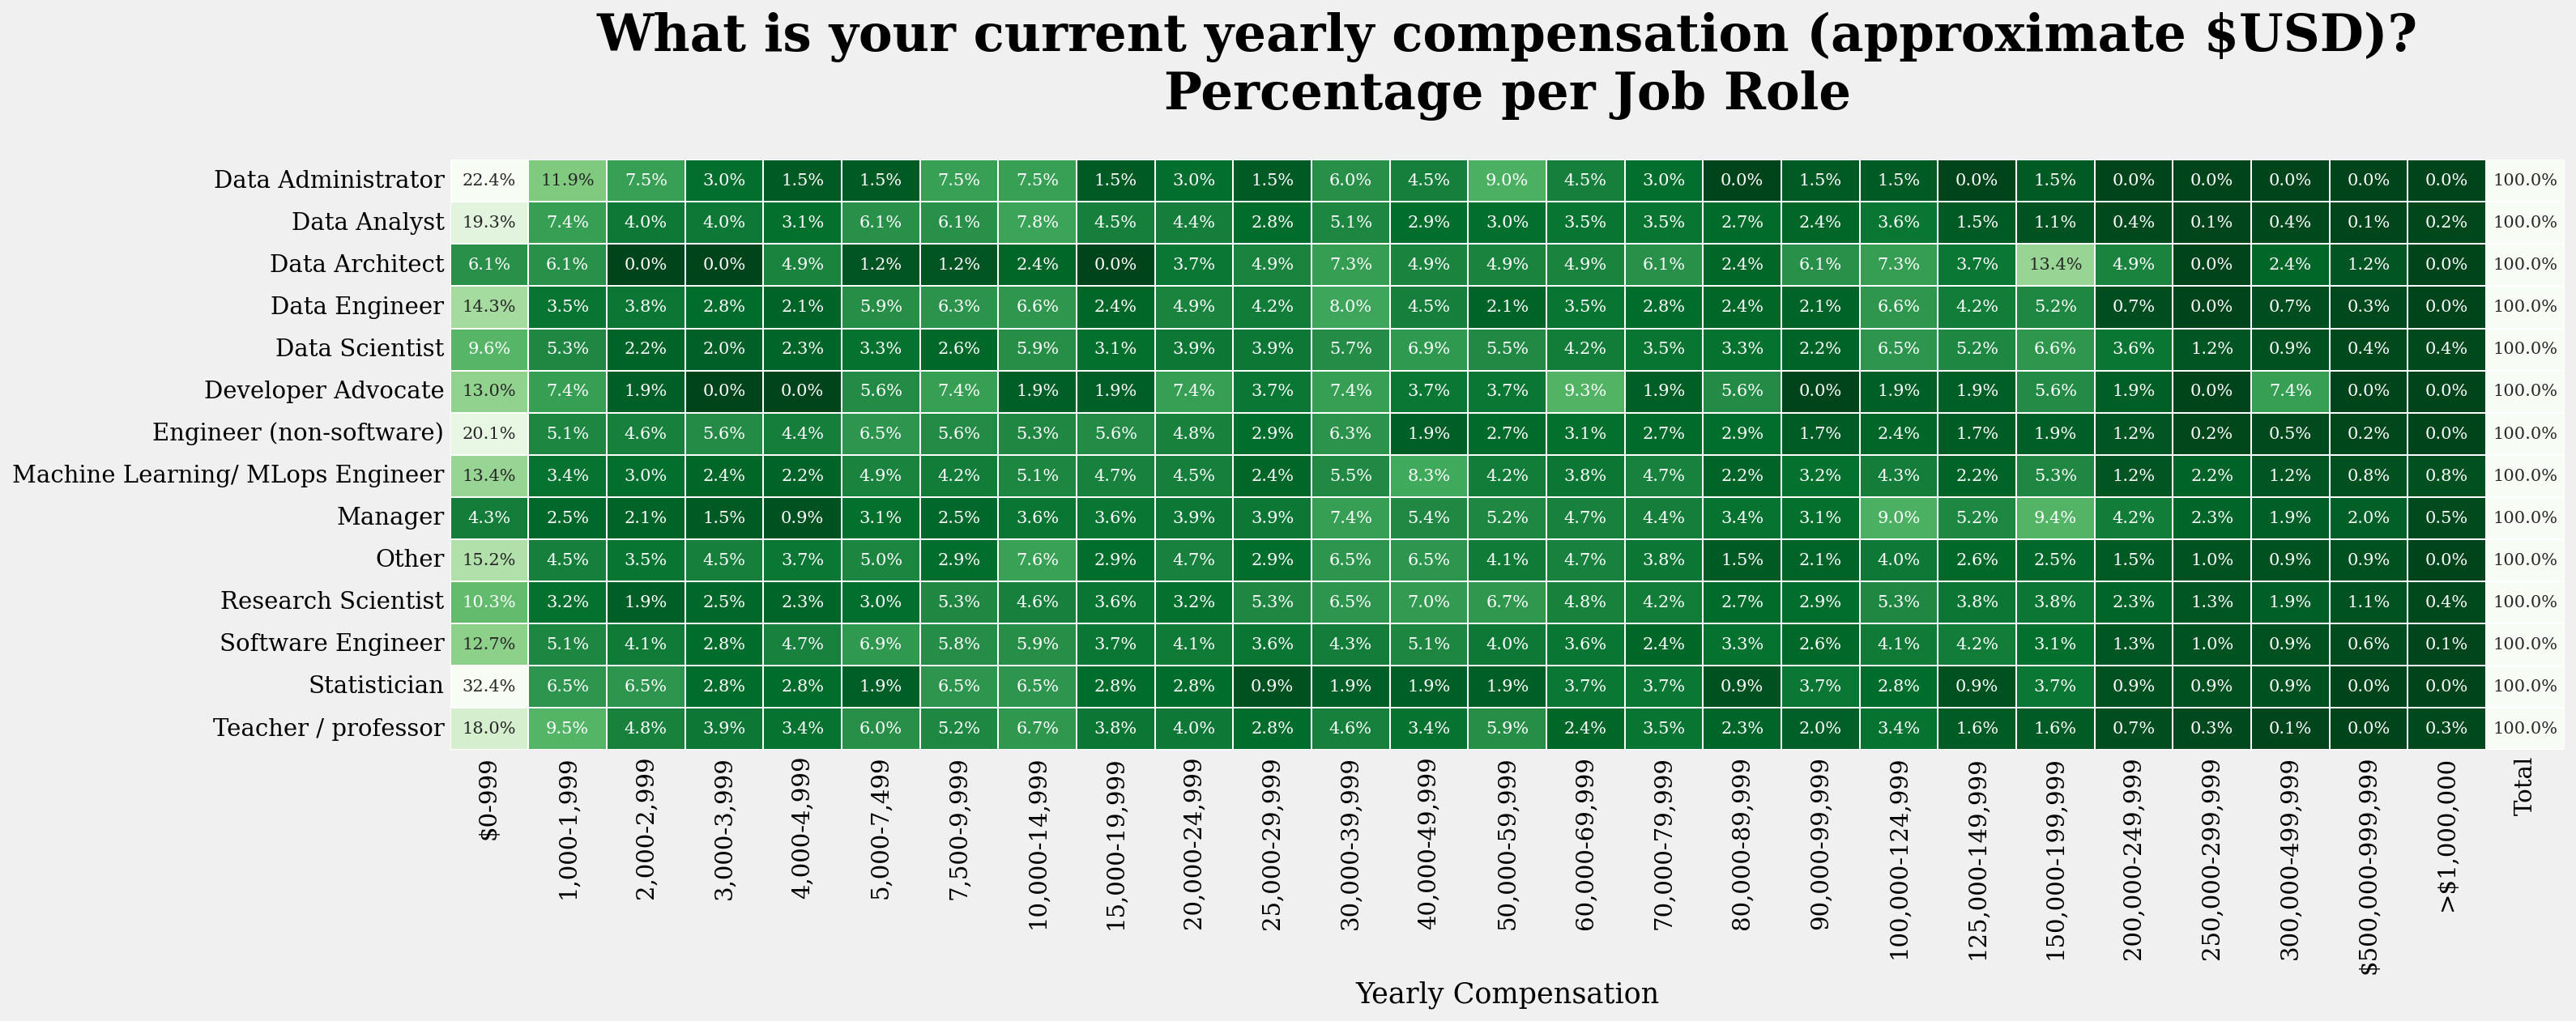

In [69]:
data= (df
    .loc[
        (df['Q23'] != 0) & (df['Q29'] != 0), :
    ]
    .assign(
        Q23= lambda df_: df_['Q23'].replace({
            'Data Analyst (Business, Marketing, Financial, Quantitative, etc)': 'Data Analyst',
            'Manager (Program, Project, Operations, Executive-level, etc)': 'Manager'
            }),
        Q29_mean= lambda df_: np.mean((df_['Q29']
            .str.replace('>', '', regex= False)
            .str.replace('$', '', regex= False)
            .replace('1,000,000', '1,000,000-1,000,000')
            .str.replace(',', '', regex= False)
            .str.split('-', expand= True)
            .astype('int')
        ), axis= 1)
    )
    .groupby(['Q23', 'Q29', 'Q29_mean'])
    .agg(
        count= ('Q23', 'size')
    )
    .reset_index()
    .assign(
        perc= lambda df_: (
            df_['count'] / (df_.groupby('Q23')['count'].transform('sum'))
        ).mul(100).round(1)
    )
    .sort_values(['Q23', 'Q29_mean'])
    .pivot_table(
        index= 'Q23',
        columns= ['Q29_mean', 'Q29'],
        values= 'perc'
    )
    .fillna(0)
    .droplevel(0, axis= 1)
    .assign(
        Total= lambda df_: df_.sum(axis= 1).round(-1)
    )
)

fig, ax= plt.subplots(figsize= (20, 6), dpi= 150)

sns.heatmap(
    data,
    ax= ax,
    cmap= 'Greens_r',
    annot= True,
    fmt= '.1f',
    annot_kws= {'fontsize': 10},
    cbar= False,
    vmax= data.max().sort_values()[-2] - 10,
    linewidths= 0.8, 
    linecolor= 'white'
)
ax.set_title(
    ''.join([map_questions['Q29'], '\nPercentage per Job Role']), 
    pad= 30, fontsize= 30, fontweight= 'bold'
)
for t in ax.texts: t.set_text(t.get_text() + "%")
ax.set_ylabel('')
ax.set_xlabel('Yearly Compensation')
ax.set_facecolor("white")
plt.show()

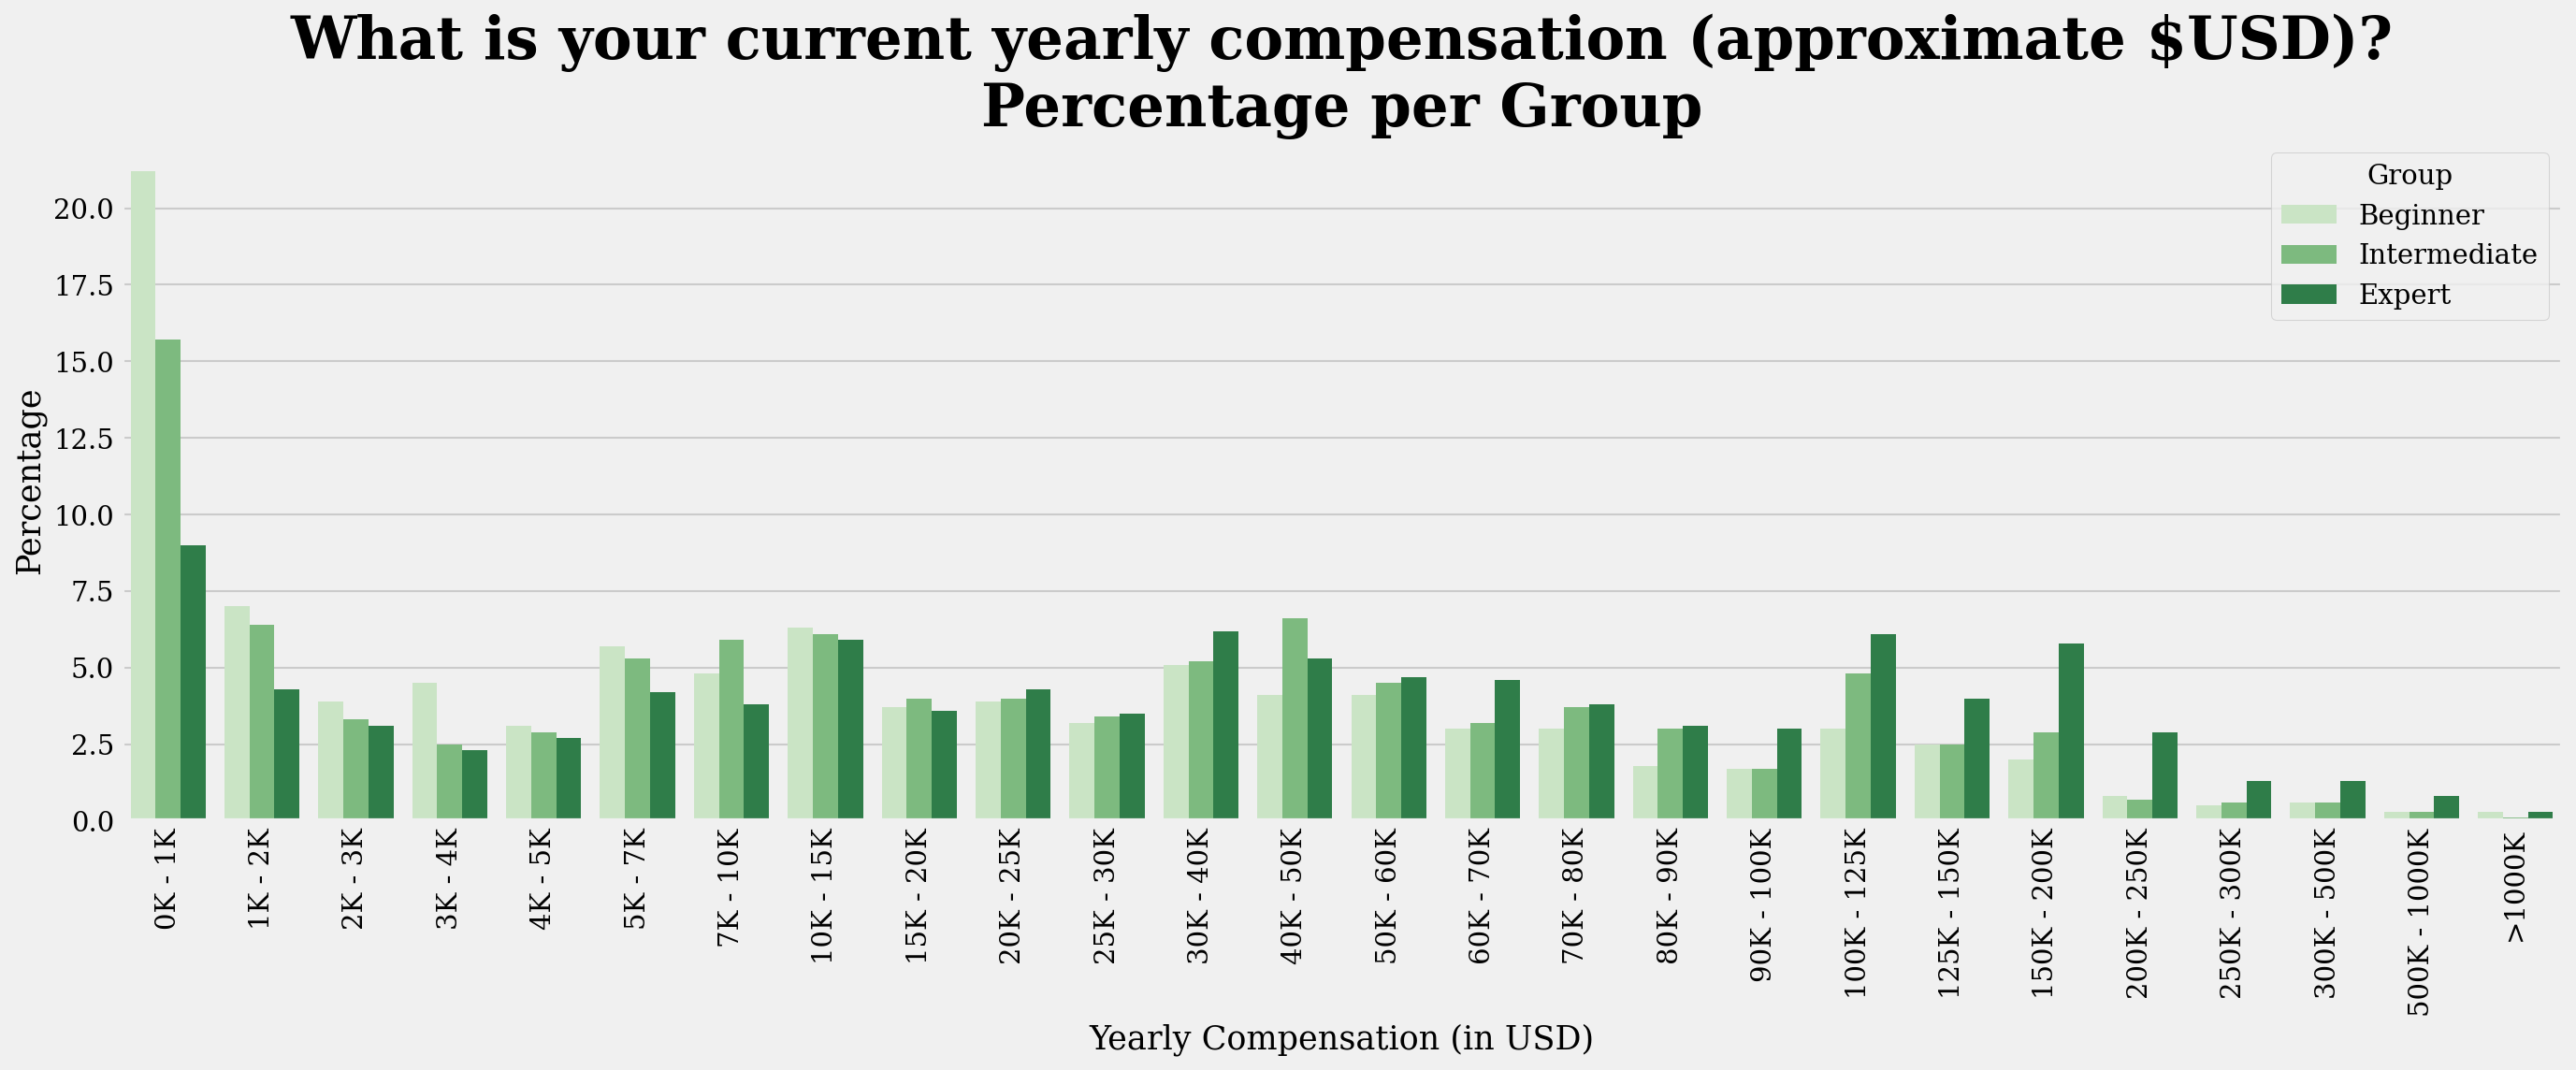

In [70]:
data= (df
    .loc[
        (df['Q23'] != 0) & (df['Q23'] != 'Currently not employed') & (df['Q29'] != 0), ['Q29', 'Group']
    ] 
    .assign(
        Q29_mean= lambda df_: np.mean((df_['Q29']
            .str.replace('>', '', regex= False)
            .str.replace('$', '', regex= False)
            .replace('1,000,000', '1,000,000-1,000,000')
            .str.replace(',', '', regex= False)
            .str.split('-', expand= True)
            .astype('int')
        ), axis= 1)
    )
    .groupby(['Group', 'Q29', 'Q29_mean'])
    .agg(count= ('Q29', 'size'))
    .reset_index()
    .loc[lambda df_: df_['count'] > 0]
    .sort_values(['Group', 'Q29_mean'])
    .assign(
        perc= lambda df_: (df_['count'] / df_.groupby('Group')['count'].transform('sum')).mul(100).round(1),
        Q29_first= (lambda df_: df_['Q29']
                   .str.split('-')
                   .str[0]
                   .str.replace(',', '', regex= False)
                   .str.replace('>', '', regex= False)
                   .str.replace('$', '', regex= False)
                   .astype('int').round(-1)
                    .div(1000).astype('int')
                   ),
        Q29_last= (lambda df_: df_['Q29']
                   .str.split('-')
                   .str[-1]
                   .str.replace(',', '', regex= False)
                   .str.replace('>', '', regex= False)
                   .str.replace('$', '', regex= False)
                   .astype('int').round(-1)
                    .div(1000).astype('int')
                   ),
    )
    .assign(
        Q29= lambda df_: (df_['Q29_first'].astype('str') + 'K - ' + df_['Q29_last'].astype('str') + 'K').replace('1000K - 1000K', '>1000K')
    )
)

fig, ax= plt.subplots(figsize= (20, 6), dpi= 150)
sns.barplot(
    x= data['Q29'], 
    y= data['perc'],
    hue= data['Group'], 
    ax= ax, 
    palette= 'Greens'
)

plt.xticks(rotation= 90)
ax.set_title(
    ''.join([map_questions['Q29'], '\nPercentage per Group']), 
    pad= 0, fontsize= 30, fontweight= 'bold'
)
ax.set_ylabel('Percentage')
ax.set_xlabel('Yearly Compensation (in USD)')
plt.show()